# Why I am learning this

# Customer segmentation using clustering & classification 
 Leveraging unsupervised learning results(k means clustering) to inform a supervised learning task.

Target: Predict new customer's behaviour(segmentation)\
Method: 
* Product clustering: Use word tokens to do product description encoding, and segment the products. 
* Customer clustering: Apply k means clustering on customers, including features derived from product segments, and assign a cluster to each customers. Use the cluster as a target lable for classification.

Business use case: Determine which new customers are likely to churn, or which marketing strategies are needed for different customers, based on their purchases.

# 1. Data Prep

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import os
from PCA_2D_3D_Visual import DimensionalityReductionPlotter, plot_pca_explained_variance
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from wordcloud import STOPWORDS, WordCloud
from sklearn import svm, tree,neighbors,linear_model, ensemble
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


In [2]:
data = pd.read_csv("Data/online retail data/data.csv", encoding="latin1")

In [3]:
data.shape

(541909, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# converting column types
data = data.dropna()
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
object_columns = data.select_dtypes(include=["object"]).columns
data[object_columns] = data[object_columns].astype("string")

data["CustomerID"] = data["CustomerID"].astype("int64").astype("string")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  string        
 1   StockCode    406829 non-null  string        
 2   Description  406829 non-null  string        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  string        
 7   Country      406829 non-null  string        
dtypes: datetime64[ns](1), float64(1), int64(1), string(5)
memory usage: 27.9 MB


In [6]:
data

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85      12680          France  
541905 2011-12-09 12:50:00       2.10      12680          France  
541906 2011-12-09 12:50:00       4.15      12680          France  
541907 2011-12-09 12:50:00       4.15      12680          France  
541908 2011-12-09 12:50:00       4.95      12680          France  

[406829 rows x 8 columns]

### Data Cleaning

In [7]:
# check special stock code
all_purchase_data = data.copy(deep=True)
list_special_codes = all_purchase_data[
    all_purchase_data["StockCode"].str.contains("^[a-zA-Z]+", regex=True)
]["StockCode"].unique()
list_special_codes

<StringArray>
['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']
Length: 8, dtype: string

In [8]:
# remove rows where invoice starts with 'A' (adjust) or 'C' (cancel)
df_cleaned = all_purchase_data[
    ~all_purchase_data["InvoiceNo"].str.startswith(tuple("AC"))
]
# remove rows where customer id is null
df_cleaned = df_cleaned.dropna(subset=["CustomerID"])

In [9]:
list_special_codes = df_cleaned[
    df_cleaned["StockCode"].str.contains("^[a-zA-Z]+", regex=True)
]["StockCode"].unique()
list_special_codes

<StringArray>
['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']
Length: 6, dtype: string

In [10]:
# removing special stock codes that are not products
df_cleaned = df_cleaned[~df_cleaned["StockCode"].isin(list_special_codes)]

In [11]:
df_cleaned.shape

(396370, 8)

### Data Transformation

#### Outliers

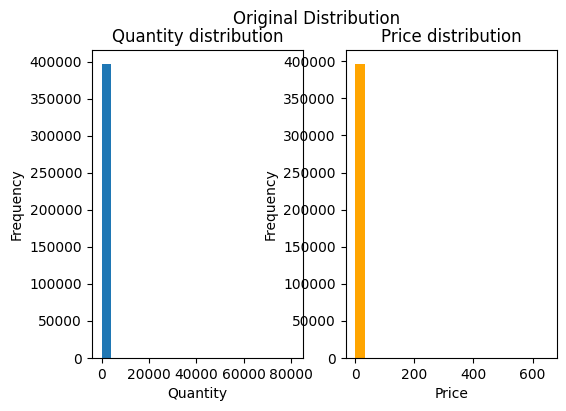

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

axes[0].hist(df_cleaned["Quantity"], bins=20)
axes[0].set_xlabel("Quantity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Quantity distribution")


axes[1].hist(df_cleaned["UnitPrice"], bins=20, color="orange")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Price distribution")

plt.suptitle("Original Distribution")
plt.show()

In [13]:
# remove outliers
df_no_outliers = df_cleaned[
    (df_cleaned["Quantity"] < 500)
    & (df_cleaned["Quantity"] > 0)
    & (df_cleaned["UnitPrice"] < 50)
    & (df_cleaned["UnitPrice"] > 0)
]

In [14]:
df_no_outliers.shape

(395741, 8)

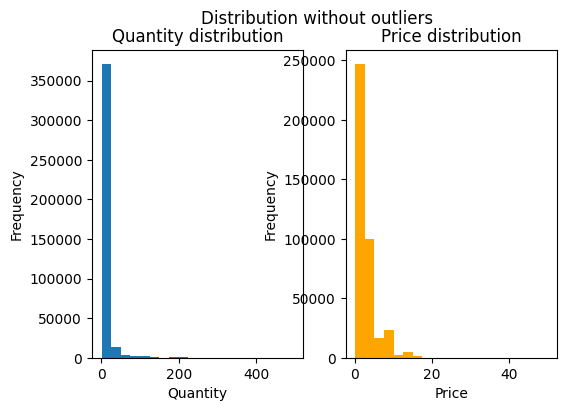

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

axes[0].hist(df_no_outliers["Quantity"], bins=20)
axes[0].set_xlabel("Quantity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Quantity distribution")


axes[1].hist(df_no_outliers["UnitPrice"], bins=20, color="orange")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Price distribution")

plt.suptitle("Distribution without outliers")
plt.show()

#### Numerical columns scaling

In [16]:
pt = PowerTransformer(method="box-cox", standardize=True, copy=True)
num_standard = pd.DataFrame(
    pt.fit_transform(df_no_outliers[["Quantity", "UnitPrice"]]),
    columns=pt.get_feature_names_out(),
)
# pt.fit_transform(df_)

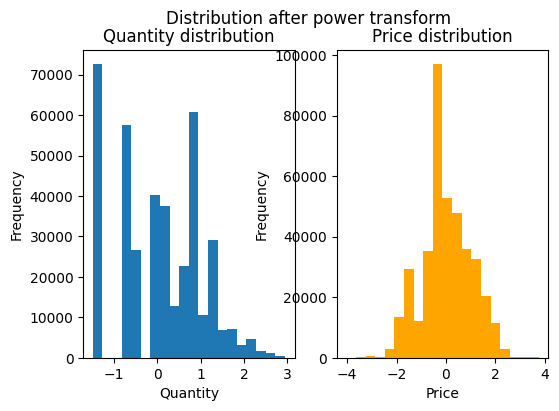

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

axes[0].hist(num_standard["Quantity"], bins=20)
axes[0].set_xlabel("Quantity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Quantity distribution")


axes[1].hist(num_standard["UnitPrice"], bins=20, color="orange")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Price distribution")

plt.suptitle("Distribution after power transform")
plt.show()

In [18]:
data_clean = df_no_outliers.reset_index(drop=True).copy(deep=True)
data_clean["Quantity_stand"] = num_standard["Quantity"]
data_clean["UnitPrice_stand"] = num_standard["UnitPrice"]

# 2. Product Clustering

## Product Encoding

In [19]:
import nltk

In [20]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /Users/graceyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/graceyang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Products by the root word

In [21]:
data_clean = df_no_outliers.copy(deep=True)

In [22]:
# checks if the first two character of the POS tag (pos[:2] are equal to NN, which denotes to nouns)
is_noun = lambda pos: pos[:2] == "NN"

stemmer = nltk.stem.SnowballStemmer("english")

# roots_words is a dictionary of all words assigned to a root, eg. {root1:{word, words}, root2:{word2}}
keywords_roots = {}

# count_keywords is a dictionary counting number of words assigned to a root. eg. {root1:2, root2:1}
count_keywords = {}

#  a list of shortest words for each root
category_keys = []

# a dictionary of {root:shortest word}
keywords_select = {}

In [23]:
# getting the nouns from the description
# def stem_noun(dataframe, column='Description'):
#   for description in dataframe[column]:
#     s = description.lower()
#     tokenized = nltk.word_tokenize(s)
#     tagged_words = nltk.pos_tag(tokenized)
#     nouns = [word for word,pos in tagged_words if is_noun(pos)]
#     list_of_words.append(nouns)


# finding the singlar form of the words from the same root
def keyword_inventory(dataframe, column):

    for description in dataframe[column]:
        # finding root for all nouns in each description
        s = description.lower()
        tokenized = nltk.word_tokenize(s)
        tagged_words = nltk.pos_tag(tokenized)
        nouns = [word for word, pos in tagged_words if is_noun(pos)]
        for w in nouns:
            w = w.lower()
            root = stemmer.stem(w)
            if root in keywords_roots:
                keywords_roots[root].add(w)
                count_keywords[root] += 1
            else:
                keywords_roots[root] = {w}
                count_keywords[root] = 1

    # finding the shortest keyword for each root
    for root in keywords_roots.keys():
        if len(keywords_roots[root]) > 1:
            min_len = 999
            for word in keywords_roots[root]:
                if len(word) < min_len:
                    min_len = len(word)
                    shortest_word = word
            category_keys.append(shortest_word)
            keywords_select[root] = shortest_word
        else:
            category_keys.append(list(keywords_roots[root])[0])
            keywords_select[root] = list(keywords_roots[root])[0]

    print("Number of keywords found {}".format(len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [24]:
df_products = pd.DataFrame(data_clean["Description"].unique()).rename(
    columns={0: "Description"}
)
keywords, keywords_roots, keywords_select, count_keywords = keyword_inventory(
    df_products, column="Description"
)

Number of keywords found 1470


In [25]:
keywords_count_df = pd.DataFrame(list(count_keywords.items())).rename(
    columns={0: "keywords", 1: "counts"}
)
keywords_count_df = keywords_count_df.sort_values(by="counts", ascending=False)
keywords_count_df

keywords  counts
0        heart     267
34      vintag     207
111        set     206
53        pink     188
75         bag     164
...        ...     ...
1057  marmalad       1
578      emerg       1
577       sing       1
573      bendi       1
1469         z       1

[1470 rows x 2 columns]

In [26]:
# colors are not useful nouns, so they are to be removed
# and remove words that don't appear frequently
# remove words contain special character
colors = ["white", "blue", "red", "cream", "pink", "black"]
less_useful_words = ["a", "z", "set"]
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in colors:
        continue
    if word in less_useful_words:
        continue
    if v < 20 or len(word) < 3:
        continue
    if ("+" in word) or ("/" in word):
        continue
    list_products.append([word, v])

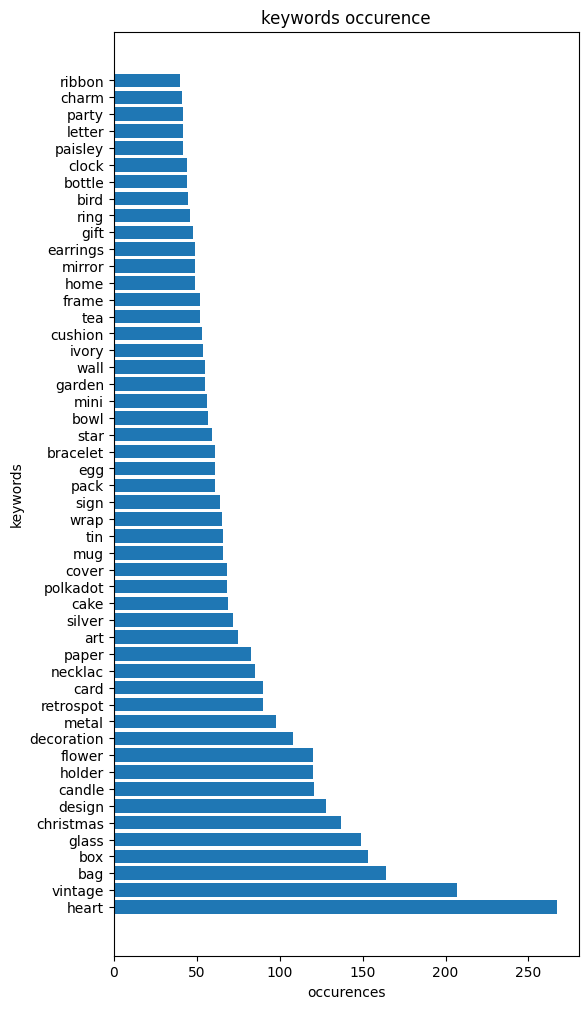

In [27]:
sorted_products = sorted(list_products, key=lambda x: x[1], reverse=True)
fig, ax = plt.subplots(figsize=(6, 12))
products = [product[0] for product in sorted_products[:50]]
occurences = [product[1] for product in sorted_products[:50]]
ax.barh(products, occurences)
ax.set_xlabel("occurences")
ax.set_ylabel("keywords")
ax.set_title("keywords occurence")
plt.show()

In [28]:
len(list_products)

131

In [29]:
X = pd.DataFrame()
liste_produits = df_cleaned["Description"].unique()
X = pd.DataFrame(index=liste_produits, columns=[key for key, _ in list_products])
for key, _ in list_products:
    X[key] = X.index.str.contains(key.upper()).astype(int)
X
# matrix = X.to_numpy()

heart  holder  metal  union  water  \
WHITE HANGING HEART T-LIGHT HOLDER       1       1      0      0      0   
WHITE METAL LANTERN                      0       0      1      0      0   
CREAM CUPID HEARTS COAT HANGER           1       0      0      0      0   
KNITTED UNION FLAG HOT WATER BOTTLE      0       0      0      1      1   
RED WOOLLY HOTTIE WHITE HEART.           1       0      0      0      0   
...                                    ...     ...    ...    ...    ...   
LETTER "W" BLING KEY RING                0       0      0      0      0   
LETTER "Z" BLING KEY RING                0       0      0      0      0   
PINK CRYSTAL SKULL PHONE CHARM           0       0      0      0      0   
CREAM HANGING HEART T-LIGHT HOLDER       1       1      0      0      0   
PAPER CRAFT , LITTLE BIRDIE              0       0      0      0      0   

                                     bottle  box  glass  star  hand  ...  \
WHITE HANGING HEART T-LIGHT HOLDER        0    0      0     0     0  ...   
WHITE METAL LANTERN                       0    0      0     0     0  ...   
CREAM CUPID HEARTS COAT HANGER            0    0      0     0     0  ...   
KNITTED UNION FLAG HOT WATER BOTTLE       1    0      0     0     0  ...   
RED WOOLLY HOTTIE WHITE HEART.            0    0      0     0     0  ...   
...                                     ...  ...    ...   ...   ...  ...   
LETTER "W" BLING KEY RING                 0    0      0     0     0  ...   
LETTER "Z" BLING KEY RING                 0    0      0     0     0  ...   
PINK CRYSTAL SKULL PHONE CHARM            0    0      0     0     0  ...   
CREAM HANGING HEART T-LIGHT HOLDER        0    0      0     0     0  ...   
PAPER CRAFT , LITTLE BIRDIE               0    0      0     0     0  ...   

                                     easter  pantry  door  retro  book  \
WHITE HANGING HEART T-LIGHT HOLDER        0       0     0      0     0   
WHITE METAL LANTERN                       0       0     0      0     0   
CREAM CUPID HEARTS COAT HANGER            0       0     0      0     0   
KNITTED UNION FLAG HOT WATER BOTTLE       0       0     0      0     0   
RED WOOLLY HOTTIE WHITE HEART.            0       0     0      0     0   
...                                     ...     ...   ...    ...   ...   
LETTER "W" BLING KEY RING                 0       0     0      0     0   
LETTER "Z" BLING KEY RING                 0       0     0      0     0   
PINK CRYSTAL SKULL PHONE CHARM            0       0     0      0     0   
CREAM HANGING HEART T-LIGHT HOLDER        0       0     0      0     0   
PAPER CRAFT , LITTLE BIRDIE               0       0     0      0     0   

                                     number  drop  earrings  shell  bead  
WHITE HANGING HEART T-LIGHT HOLDER        0     0         0      0     0  
WHITE METAL LANTERN                       0     0         0      0     0  
CREAM CUPID HEARTS COAT HANGER            0     0         0      0     0  
KNITTED UNION FLAG HOT WATER BOTTLE       0     0         0      0     0  
RED WOOLLY HOTTIE WHITE HEART.            0     0         0      0     0  
...                                     ...   ...       ...    ...   ...  
LETTER "W" BLING KEY RING                 0     0         0      0     0  
LETTER "Z" BLING KEY RING                 0     0         0      0     0  
PINK CRYSTAL SKULL PHONE CHARM            0     0         0      0     0  
CREAM HANGING HEART T-LIGHT HOLDER        0     0         0      0     0  
PAPER CRAFT , LITTLE BIRDIE               0     0         0      0     0  

[3871 rows x 131 columns]

###  Kmeans segmentation 

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#### Elbow chart to find the optimum number of clusters


/Users/graceyang/Library/Python/3.9/lib/python/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/graceyang/Library/Python/3.9/lib/python/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


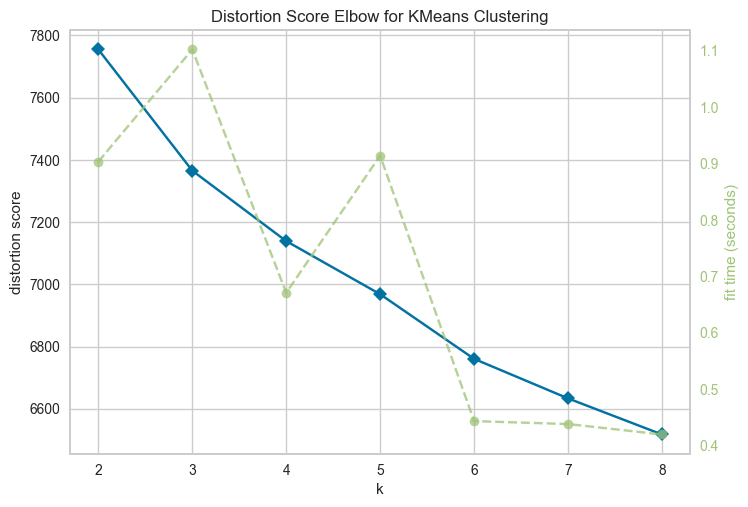

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
k_range = range(2, 9)
visualizer = KElbowVisualizer(KMeans(n_init=20), k=k_range, random_state=64)
visualizer.fit(X)
visualizer.show()

#### Silhouette visual to validate the options from Elbow

Clusters are not well seperated, as there is alwasy a dominant cluster, and silhouete score is small

In [32]:
def silhouette_plots(df, k_range=range(2, 8), num_rows=2):
    """
    Plot multiple silhouette plots for a range of k clusters using KMeans clustering.

    Parameters:
    df: pandas dataframe to be fit with KMeans;
    k_range: a range of number of clusters;
    num_rows: number of rows in the multiple plots.
    """
    num_cols = (
        len(k_range) + num_rows - 1
    ) // num_rows  # Calculate the number of columns needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for ax in axes[len(k_range) :]:
        fig.delaxes(ax)  # Remove any unused subplots

    for i, n_clusters in enumerate(k_range):
        kmeans = KMeans(n_clusters=n_clusters, random_state=32, n_init=50)
        visualizer = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=axes[i])
        visualizer.fit(df)

        axes[i].set_title(
            f"The Silhouette Plot for n_clusters = {n_clusters}", fontsize=16
        )
        axes[i].set_xlabel("The silhouette coefficient values", fontsize=14)
        axes[i].set_ylabel("Cluster label", fontsize=14)

    plt.tight_layout()
    plt.show()

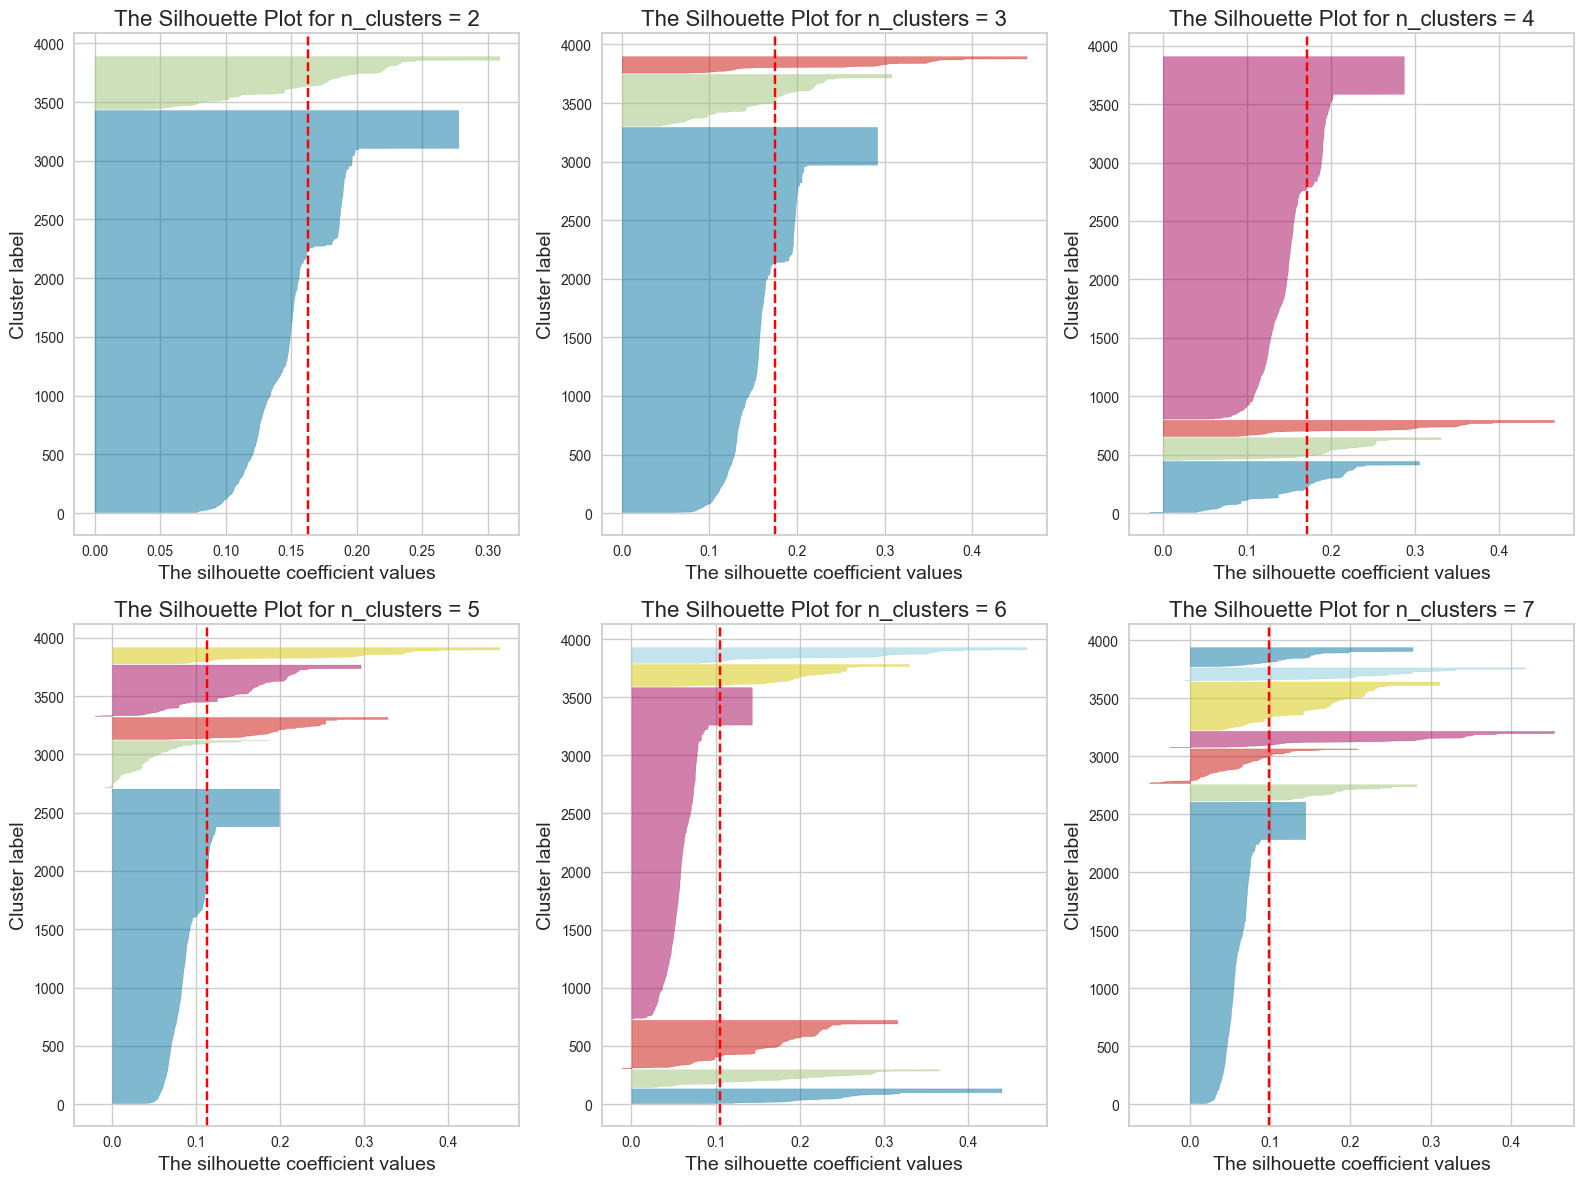

In [33]:
silhouette_plots(X)

There is always a dominant cluster, closer examing the products in each cluster

In [34]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=100)
product_clusters = kmeans.fit_predict(X)

In [35]:
products_clusters = pd.DataFrame(liste_produits, columns=["Description"])
products_clusters["cluster"] = product_clusters
products_clusters.agg("cluster").value_counts()

cluster
1    3102
2     441
3     189
0     139
Name: count, dtype: int64

In [36]:
products_clusters[products_clusters["cluster"] == 1]

Description  cluster
1                     WHITE METAL LANTERN        1
3     KNITTED UNION FLAG HOT WATER BOTTLE        1
5            SET 7 BABUSHKA NESTING BOXES        1
6       GLASS STAR FROSTED T-LIGHT HOLDER        1
7                  HAND WARMER UNION JACK        1
...                                   ...      ...
3865            LETTER "U" BLING KEY RING        1
3866            LETTER "W" BLING KEY RING        1
3867            LETTER "Z" BLING KEY RING        1
3868       PINK CRYSTAL SKULL PHONE CHARM        1
3870          PAPER CRAFT , LITTLE BIRDIE        1

[3102 rows x 2 columns]

### Clusters imbalance

Removed some key word after eximing each cluster, as some small clusters appear to be clustering certain colors or a speicicif word ('SET'). However the unbalanced size in clusters didn't change by removing those words.

In [37]:
#  adding price
product_price = df_cleaned.groupby("Description", as_index=False)["UnitPrice"].mean()
price_bins = [0, 1, 2, 3, 5, float("inf")]
price_labels = [0, 1, 2, 3, 5]
product_price["PriceRange"] = pd.cut(
    product_price["UnitPrice"], bins=price_bins, labels=price_labels, right=False
)
product_price

Description  UnitPrice PriceRange
0        4 PURPLE FLOCK DINNER CANDLES   2.324359          2
1        50'S CHRISTMAS GIFT BAG LARGE   1.248073          1
2                    DOLLY GIRL BEAKER   1.243841          1
3          I LOVE LONDON MINI BACKPACK   4.138571          3
4          I LOVE LONDON MINI RUCKSACK   4.150000          3
...                                ...        ...        ...
3866   ZINC T-LIGHT HOLDER STARS SMALL   0.836975          0
3867    ZINC TOP  2 DOOR WOODEN SHELF   16.950000          5
3868  ZINC WILLIE WINKIE  CANDLE STICK   0.872344          0
3869       ZINC WIRE KITCHEN ORGANISER   7.175000          5
3870  ZINC WIRE SWEETHEART LETTER TRAY   3.454000          3

[3871 rows x 3 columns]

In [38]:
product_price.agg("PriceRange").value_counts()

PriceRange
1    1012
0     960
2     672
5     618
3     609
Name: count, dtype: int64

choosing the size of the each price bin to balance each bin 

In [39]:
X_reset = X.reset_index()
X_reset.rename(columns={"index": "Description"}, inplace=True)
X_merged = X_reset.merge(
    product_price[["Description", "PriceRange"]], on="Description", how="inner"
)
X_final = X_merged.set_index("Description")
X_final

heart  holder  metal  union  water  \
Description                                                               
WHITE HANGING HEART T-LIGHT HOLDER       1       1      0      0      0   
WHITE METAL LANTERN                      0       0      1      0      0   
CREAM CUPID HEARTS COAT HANGER           1       0      0      0      0   
KNITTED UNION FLAG HOT WATER BOTTLE      0       0      0      1      1   
RED WOOLLY HOTTIE WHITE HEART.           1       0      0      0      0   
...                                    ...     ...    ...    ...    ...   
LETTER "W" BLING KEY RING                0       0      0      0      0   
LETTER "Z" BLING KEY RING                0       0      0      0      0   
PINK CRYSTAL SKULL PHONE CHARM           0       0      0      0      0   
CREAM HANGING HEART T-LIGHT HOLDER       1       1      0      0      0   
PAPER CRAFT , LITTLE BIRDIE              0       0      0      0      0   

                                     bottle  box  glass  star  hand  ...  \
Description                                                          ...   
WHITE HANGING HEART T-LIGHT HOLDER        0    0      0     0     0  ...   
WHITE METAL LANTERN                       0    0      0     0     0  ...   
CREAM CUPID HEARTS COAT HANGER            0    0      0     0     0  ...   
KNITTED UNION FLAG HOT WATER BOTTLE       1    0      0     0     0  ...   
RED WOOLLY HOTTIE WHITE HEART.            0    0      0     0     0  ...   
...                                     ...  ...    ...   ...   ...  ...   
LETTER "W" BLING KEY RING                 0    0      0     0     0  ...   
LETTER "Z" BLING KEY RING                 0    0      0     0     0  ...   
PINK CRYSTAL SKULL PHONE CHARM            0    0      0     0     0  ...   
CREAM HANGING HEART T-LIGHT HOLDER        0    0      0     0     0  ...   
PAPER CRAFT , LITTLE BIRDIE               0    0      0     0     0  ...   

                                     pantry  door  retro  book  number  drop  \
Description                                                                    
WHITE HANGING HEART T-LIGHT HOLDER        0     0      0     0       0     0   
WHITE METAL LANTERN                       0     0      0     0       0     0   
CREAM CUPID HEARTS COAT HANGER            0     0      0     0       0     0   
KNITTED UNION FLAG HOT WATER BOTTLE       0     0      0     0       0     0   
RED WOOLLY HOTTIE WHITE HEART.            0     0      0     0       0     0   
...                                     ...   ...    ...   ...     ...   ...   
LETTER "W" BLING KEY RING                 0     0      0     0       0     0   
LETTER "Z" BLING KEY RING                 0     0      0     0       0     0   
PINK CRYSTAL SKULL PHONE CHARM            0     0      0     0       0     0   
CREAM HANGING HEART T-LIGHT HOLDER        0     0      0     0       0     0   
PAPER CRAFT , LITTLE BIRDIE               0     0      0     0       0     0   

                                     earrings  shell  bead  PriceRange  
Description                                                             
WHITE HANGING HEART T-LIGHT HOLDER          0      0     0           2  
WHITE METAL LANTERN                         0      0     0           3  
CREAM CUPID HEARTS COAT HANGER              0      0     0           3  
KNITTED UNION FLAG HOT WATER BOTTLE         0      0     0           3  
RED WOOLLY HOTTIE WHITE HEART.              0      0     0           3  
...                                       ...    ...   ...         ...  
LETTER "W" BLING KEY RING                   0      0     0           0  
LETTER "Z" BLING KEY RING                   0      0     0           0  
PINK CRYSTAL SKULL PHONE CHARM              0      0     0           0  
CREAM HANGING HEART T-LIGHT HOLDER          0      0     0           2  
PAPER CRAFT , LITTLE BIRDIE                 0      0     0           2  

[3871 rows x 132 columns]

In [40]:
enc = OneHotEncoder(handle_unknown="ignore")
price_encoded = enc.fit_transform(X_final[["PriceRange"]])
price_encoded_df = pd.DataFrame(
    price_encoded.toarray(),
    index=X_final.index,
    columns=enc.get_feature_names_out(["PriceRange"]),
)
X_final_encoded = pd.concat([X_final, price_encoded_df], axis=1).drop(
    columns=["PriceRange"]
)

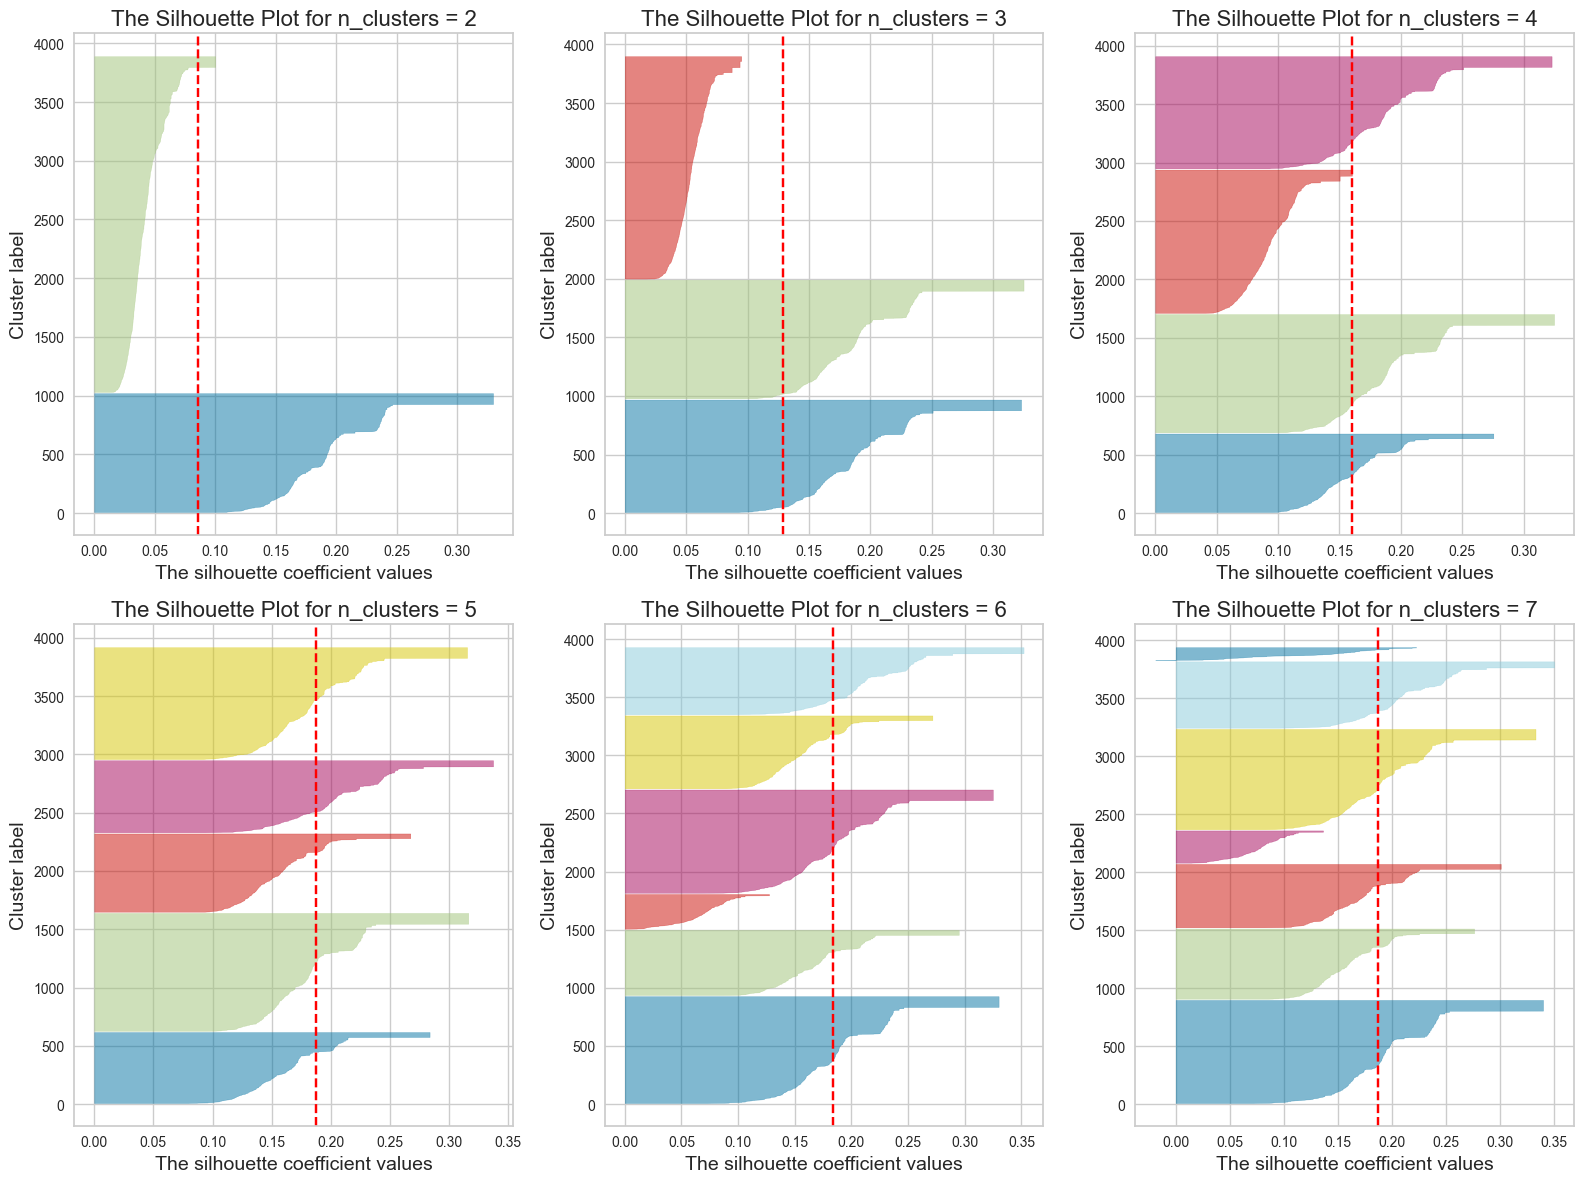

In [41]:
silhouette_plots(X_final_encoded)

Now the cluster size are balanced, and n_cluster= 5 is a good choice of clustering

In [42]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=100)
product_clusters = kmeans.fit_predict(X_final_encoded)

### Validation

#### Word cloud visual

In [43]:
# making a list of 5 dictionaries, and each ditionaries count the number of occurences for each word in list_products
n_clusters = k
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[product_clusters == i]
    for word in liste_words:
        if word in ["pink", "blue", "ass", "i", "W"]:
            continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [44]:
# Wordclouds making
def random_color_func(
    word=None,
    font_size=None,
    position=None,
    orientation=None,
    font_path=None,
    random_state=None,
):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = liste[0:100]
    for s in trunc_occurences:
        words[s[0]] = s[1]

    wordcloud = WordCloud(
        width=1000,
        height=400,
        background_color="lightgrey",
        max_words=1628,
        relative_scaling=1,
        color_func=random_color_func,
        normalize_plurals=False,
    )
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis("off")
    plt.title("cluster {}".format(increment - 1))

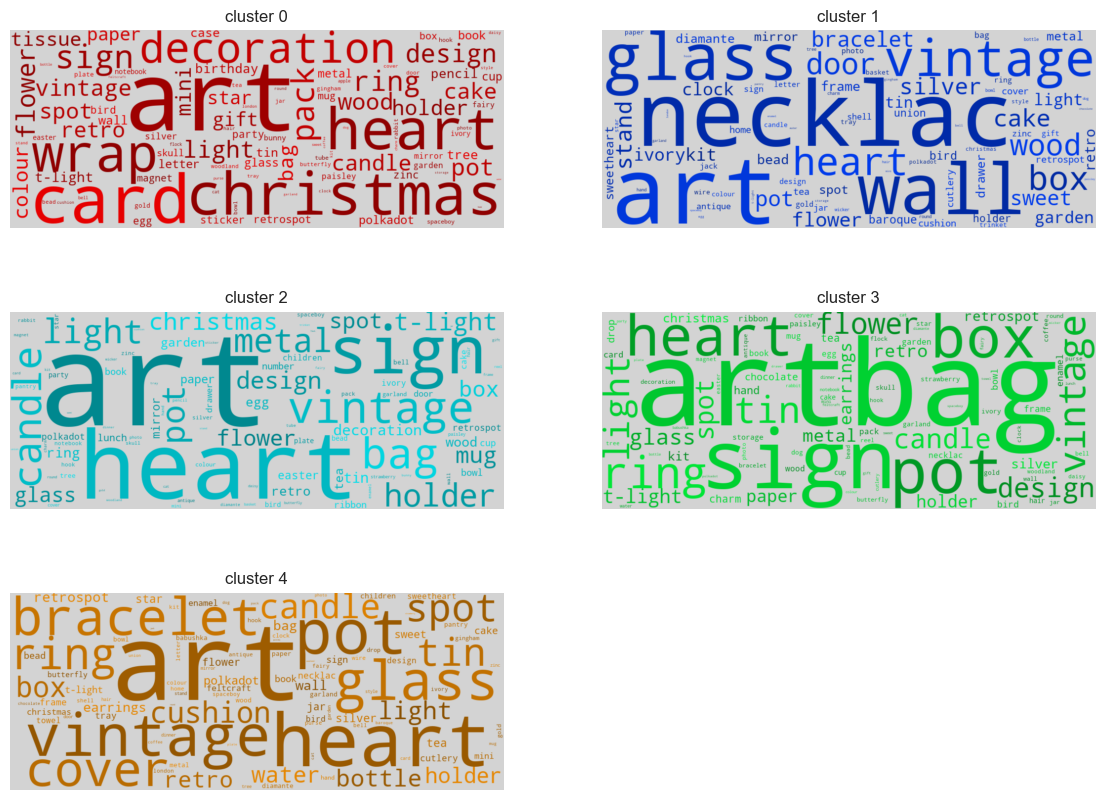

In [45]:
fig = plt.figure(1, figsize=(14, 14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(k):
    list_cluster_occurences = occurence[i]

    tone = color[i]  # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key=lambda x: x[1], reverse=True)
    make_wordcloud(liste, i + 1)

Some differences are in each cluster, for example one is around christmas, one is around jewery, but they all contain similar words. So let's see if the clusters are well sepearted as we have a price range inserted for the clustering.

#### 2D cluster visual

In [46]:
plotter = DimensionalityReductionPlotter(
    X_final_encoded, product_clusters, dimensions=2, method="tsne"
)
plotter.plot_reduced_dimensions(opacity=1, width_line=0.1)

Using TSNE dimension reduction, the 5 clusters look well sepearted 

# 3. Customer Features

Since the data only have information on the products order information, the features will be built around the order size, order frequency, along with the product cluters from the above section. 

In [47]:
# orders count, average order value, days between orders

In [48]:
df_no_outliers

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85      12680          France  
541905 2011-12-09 12:50:00       2.10      12680          France  
541906 2011-12-09 12:50:00       4.15      12680          France  
541907 2011-12-09 12:50:00       4.15      12680          France  
541908 2011-12-09 12:50:00       4.95      12680          France  

[395741 rows x 8 columns]

In [49]:
all_customer_data = df_no_outliers[
    [
        "InvoiceNo",
        "InvoiceDate",
        "Description",
        "Quantity",
        "UnitPrice",
        "CustomerID",
        "Country",
    ]
]

In [50]:
products_data = pd.DataFrame(product_price.loc[:, "Description"])
products_data["ProductCluster"] = product_clusters
products_data.head(2)

Description  ProductCluster
0   4 PURPLE FLOCK DINNER CANDLES               3
1   50'S CHRISTMAS GIFT BAG LARGE               4

In [51]:
# one row per item per invoice
all_customer_data = all_customer_data.merge(products_data, "left", on="Description")
# all_customer_data.drop('product_cluster', axis=1, inplace=True)
all_customer_data

InvoiceNo         InvoiceDate                          Description  \
0         536365 2010-12-01 08:26:00   WHITE HANGING HEART T-LIGHT HOLDER   
1         536365 2010-12-01 08:26:00                  WHITE METAL LANTERN   
2         536365 2010-12-01 08:26:00       CREAM CUPID HEARTS COAT HANGER   
3         536365 2010-12-01 08:26:00  KNITTED UNION FLAG HOT WATER BOTTLE   
4         536365 2010-12-01 08:26:00       RED WOOLLY HOTTIE WHITE HEART.   
...          ...                 ...                                  ...   
395736    581587 2011-12-09 12:50:00          PACK OF 20 SPACEBOY NAPKINS   
395737    581587 2011-12-09 12:50:00         CHILDREN'S APRON DOLLY GIRL    
395738    581587 2011-12-09 12:50:00        CHILDRENS CUTLERY DOLLY GIRL    
395739    581587 2011-12-09 12:50:00      CHILDRENS CUTLERY CIRCUS PARADE   
395740    581587 2011-12-09 12:50:00        BAKING SET 9 PIECE RETROSPOT    

        Quantity  UnitPrice CustomerID         Country  ProductCluster  
0              6       2.55      17850  United Kingdom               4  
1              6       3.39      17850  United Kingdom               4  
2              8       2.75      17850  United Kingdom               1  
3              6       3.39      17850  United Kingdom               0  
4              6       3.39      17850  United Kingdom               2  
...          ...        ...        ...             ...             ...  
395736        12       0.85      12680          France               1  
395737         6       2.10      12680          France               0  
395738         4       4.15      12680          France               0  
395739         4       4.15      12680          France               0  
395740         3       4.95      12680          France               2  

[395741 rows x 8 columns]

## Split train test customers

In [52]:
# choose 20% of customers for test
all_customer_ids = pd.DataFrame(
    all_customer_data["CustomerID"].unique(), columns=["CustomerID"]
)
sample_size = int(len(all_customer_ids) * 0.2)
sample_customer_ids = all_customer_ids.sample(n=sample_size, random_state=13)
test_customers = all_customer_data["CustomerID"].isin(sample_customer_ids["CustomerID"])

test_customers_df = all_customer_data[test_customers]
train_customers_df = all_customer_data[~test_customers]

In [53]:
# creating orderSequence for testing on customers with less than 3 orders
# test_customers_df.loc[:,'orderSequence'] = test_customers_df['InvoiceDate'].rank(method='first')

In [54]:
train_customers_df.head(4)

InvoiceNo         InvoiceDate                          Description  \
0    536365 2010-12-01 08:26:00   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365 2010-12-01 08:26:00                  WHITE METAL LANTERN   
2    536365 2010-12-01 08:26:00       CREAM CUPID HEARTS COAT HANGER   
3    536365 2010-12-01 08:26:00  KNITTED UNION FLAG HOT WATER BOTTLE   

   Quantity  UnitPrice CustomerID         Country  ProductCluster  
0         6       2.55      17850  United Kingdom               4  
1         6       3.39      17850  United Kingdom               4  
2         8       2.75      17850  United Kingdom               1  
3         6       3.39      17850  United Kingdom               0

## Making customers table

In [55]:
def customer_table_build(df):
    basket_data = pd.DataFrame()
    pivot_df = pd.DataFrame()
    customer_basket = pd.DataFrame()

    hypothetical_today = df["InvoiceDate"].max() + pd.Timedelta(days=1)

    df.loc[:, "TotalPrice"] = df["Quantity"] * df["UnitPrice"]
    basket_data = (
        df.groupby(
            ["InvoiceNo", "InvoiceDate", "CustomerID", "Country", "ProductCluster"]
        )
        .agg({"TotalPrice": "sum", "Quantity": "sum"})
        .reset_index()
    )

    TotalQuantity = (
        basket_data.groupby("InvoiceNo").agg({"Quantity": "sum"}).reset_index()
    )
    pivot_df = basket_data.pivot_table(
        index=["InvoiceNo", "InvoiceDate", "CustomerID", "Country"],
        columns="ProductCluster",
        values="TotalPrice",
        aggfunc="sum",
        fill_value=0,
    )
    pivot_df.rename(
        columns={
            0: "Category0",
            1: "Category1",
            2: "Category2",
            3: "Category3",
            4: "Category4",
        },
        inplace=True,
    )
    pivot_df.columns.name = None
    pivot_df.reset_index(inplace=True)
    pivot_df.loc[:, "BasketPrice"] = (
        pivot_df["Category0"]
        + pivot_df["Category1"]
        + pivot_df["Category2"]
        + pivot_df["Category3"]
        + pivot_df["Category4"]
    )
    for i in range(5):
        pivot_df["Category{}".format(i)] = (
            pivot_df["Category{}".format(i)] / pivot_df["BasketPrice"] *100
        )
    pivot_df = pivot_df.merge(TotalQuantity, how="left", on="InvoiceNo")

    customer_basket = (
        pivot_df.groupby("CustomerID")
        .agg(
            orderCounts=("InvoiceNo", "count"),
            minPrice = ("BasketPrice","min"),
            avgPrice=("BasketPrice", "mean"),
            maxPrice = ("BasketPrice","max"),
            totalPrice=("BasketPrice", "sum"),
            avgQuantity=("Quantity", "mean"),
            firstOrder=("InvoiceDate", "min"),
            lastOrder=("InvoiceDate", "max"),
        )
        .reset_index()
    )
    customer_basket.loc[:, "daysBetweenOrders"] = (
        (customer_basket["lastOrder"] - customer_basket["firstOrder"]).dt.days
    ) / (customer_basket["orderCounts"] - 1)
    customer_basket.loc[:, "customerAgeDays"] = (
        hypothetical_today - customer_basket["firstOrder"]
    ).dt.days

    category_df = (
        pivot_df.groupby(["CustomerID", "Country"])
        .agg(
            {
                "Category0": "mean",
                "Category1": "mean",
                "Category2": "mean",
                "Category3": "mean",
                "Category4": "mean",
            }
        )
        .reset_index()
    )
    all_customers_df = customer_basket.merge(category_df, on="CustomerID")
    all_customers_df["daysBetweenOrders"].fillna(999, inplace=True)
    return all_customers_df

In [56]:
# train data before scaling
agg_train = pd.DataFrame()
agg_train = customer_table_build(train_customers_df)
agg_train

/var/folders/kx/nkzqwzjs41n65h84y4twk5yr0000gn/T/ipykernel_70411/1273177989.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CustomerID  orderCounts  minPrice     avgPrice  maxPrice  totalPrice  \
0         12348            4    187.44   359.310000    652.80     1437.24   
1         12349            1   1457.55  1457.550000   1457.55     1457.55   
2         12350            1    294.40   294.400000    294.40      294.40   
3         12352            7    104.35   197.962857    296.50     1385.74   
4         12353            1     89.00    89.000000     89.00       89.00   
...         ...          ...       ...          ...       ...         ...   
3455      18278            1    173.90   173.900000    173.90      173.90   
3456      18280            1    180.60   180.600000    180.60      180.60   
3457      18281            1     80.82    80.820000     80.82       80.82   
3458      18283           16      1.95   130.558125    313.65     2088.93   
3459      18287            3     70.68   612.426667   1001.32     1837.28   

      avgQuantity          firstOrder           lastOrder  daysBetweenOrders  \
0      583.000000 2010-12-16 19:09:00 2011-09-25 13:13:00          94.000000   
1      630.000000 2011-11-21 09:51:00 2011-11-21 09:51:00         999.000000   
2      196.000000 2011-02-02 16:01:00 2011-02-02 16:01:00         999.000000   
3       75.142857 2011-02-16 12:33:00 2011-11-03 14:37:00          43.333333   
4       20.000000 2011-05-19 17:47:00 2011-05-19 17:47:00         999.000000   
...           ...                 ...                 ...                ...   
3455    66.000000 2011-09-27 11:58:00 2011-09-27 11:58:00         999.000000   
3456    45.000000 2011-03-07 09:52:00 2011-03-07 09:52:00         999.000000   
3457    54.000000 2011-06-12 10:53:00 2011-06-12 10:53:00         999.000000   
3458    87.187500 2011-01-06 14:14:00 2011-12-06 12:02:00          22.200000   
3459   528.666667 2011-05-22 10:39:00 2011-10-28 09:29:00          79.000000   

      customerAgeDays         Country  Category0  Category1  Category2  \
0                 358         Finland   8.431977   6.755797  44.923369   
1                  19           Italy  19.957463  18.280676  27.929745   
2                 310          Norway  34.273098  11.820652  32.404891   
3                 297          Norway  13.378619  16.083982  31.003267   
4                 204         Bahrain  13.033708   0.000000  86.966292   
...               ...             ...        ...        ...        ...   
3455               74  United Kingdom  28.464635  18.401380  36.055204   
3456              278  United Kingdom   9.800664   0.000000  38.122924   
3457              181  United Kingdom  33.444692   0.000000  39.903489   
3458              337  United Kingdom  19.992823  17.559519  20.404050   
3459              202  United Kingdom   9.235340  14.638200  48.106641   

      Category3  Category4  
0      7.113971  32.774887  
1     14.234160  19.597955  
2     15.489130   6.012228  
3     17.564062  21.970069  
4      0.000000   0.000000  
...         ...        ...  
3455   0.000000  17.078781  
3456  33.970100  18.106312  
3457   6.236080  20.415739  
3458  21.873915  20.169692  
3459   7.370541  20.649279  

[3460 rows x 17 columns]

## Scaling

In [57]:
pt = PowerTransformer(method="yeo-johnson", standardize=True, copy=True)
num_sca = pd.DataFrame(
    pt.fit_transform(
        agg_train[
            [
                "orderCounts",
                "minPrice",
                "avgPrice",
                "maxPrice",
                "totalPrice",
                "avgQuantity",
                "daysBetweenOrders",
                "customerAgeDays",
                "Category0",
                "Category1",
                "Category2",
                "Category3",
                "Category4",
            ]
        ]
    ),
    columns=pt.get_feature_names_out(),
)

## One hot encoding

In [58]:
enc = OneHotEncoder(handle_unknown="ignore")
country_encoded = pd.DataFrame.sparse.from_spmatrix(
    enc.fit_transform(agg_train[["Country"]]), columns=enc.get_feature_names_out()
)

## Training data processed

In [59]:
# train data after scaling and one hot encoding
# customer_train_data = pd.concat([num_sca, country_encoded], axis=1)
customer_train_data=num_sca
customer_train_data

orderCounts  minPrice  avgPrice  maxPrice  totalPrice  avgQuantity  \
0        0.683237  0.137240  0.352402  0.678231    0.608471     1.655207   
1       -1.141067  2.646035  2.322853  1.601552    0.619208     1.765081   
2       -1.141067  0.601088  0.080775 -0.248539   -0.667690     0.235281   
3        1.217115 -0.402141 -0.453678 -0.240220    0.580505    -0.837042   
4       -1.141067 -0.537382 -1.502842 -1.658699   -1.714741    -2.074526   
...           ...       ...       ...       ...         ...          ...   
3455    -1.141067  0.064391 -0.626289 -0.866863   -1.119604    -0.970455   
3456    -1.141067  0.100977 -0.576037 -0.822329   -1.086683    -1.348719   
3457    -1.141067 -0.617099 -1.626773 -1.773003   -1.802192    -1.171529   
3458     1.750926 -2.607185 -1.004661 -0.174434    0.891344    -0.680818   
3459     0.351780 -0.725213  1.090088  1.171470    0.794993     1.518328   

      daysBetweenOrders  customerAgeDays  Category0  Category1  Category2  \
0             -0.303673         1.130019  -1.106600  -0.900724   1.365525   
1              1.212636        -1.775879  -0.108777   0.185017   0.328768   
2              1.212636         0.746147   0.870760  -0.359973   0.620386   
3             -0.741783         0.641304  -0.642086   0.012265   0.530756   
4              1.212636        -0.121993  -0.672310  -2.145752   3.427570   
...                 ...              ...        ...        ...        ...   
3455           1.212636        -1.249535   0.495395   0.194203   0.847304   
3456           1.212636         0.487334  -0.970531  -2.145752   0.972037   
3457           1.212636        -0.315116   0.818710  -2.145752   1.077437   
3458          -1.095509         0.962674  -0.106095   0.129496  -0.204295   
3459          -0.404581        -0.138706  -1.025910  -0.107863   1.541969   

      Category3  Category4  
0     -0.876388   1.447731  
1     -0.163866   0.530278  
2     -0.058912  -0.824168  
3      0.105518   0.713186  
4     -2.190652  -1.992189  
...         ...        ...  
3455  -2.190652   0.324272  
3456   1.152491   0.409905  
3457  -0.985252   0.594453  
3458   0.417747   0.575274  
3459  -0.845792   0.612557  

[3460 rows x 13 columns]

# 4. Create Customer Clusters 

## Assess the variance

Function called successfully


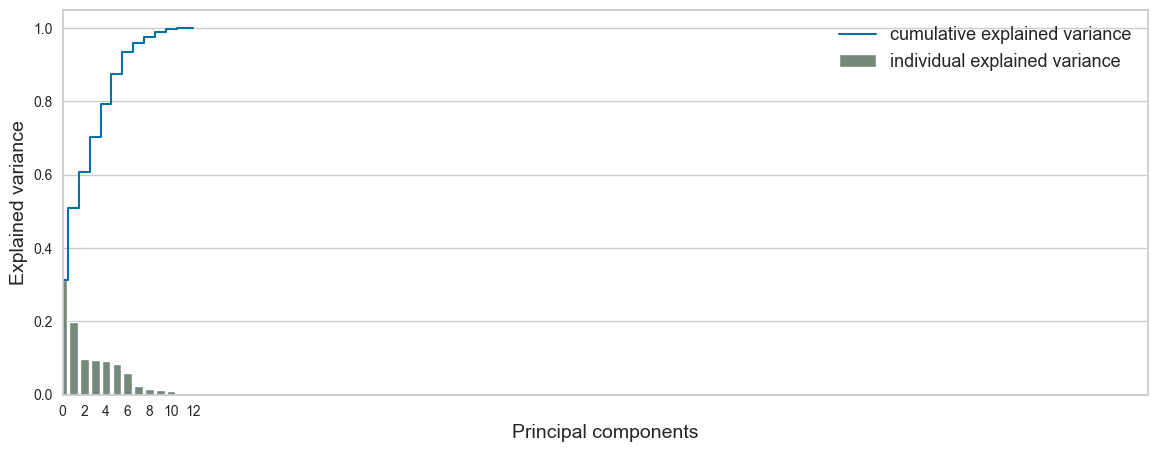

In [60]:
pca = PCA()
pca.fit(customer_train_data)
plot_pca_explained_variance(customer_train_data, pca)

With 6 components explianed 80% of the vairnace, it maybe beneficial to use PCA before clustering.

## PCA

In [61]:
pca = PCA(n_components=7)
customer_train_data_ = pd.DataFrame(
    pca.fit_transform(customer_train_data), columns=pca.get_feature_names_out()
)

In [62]:
customer_train_data_

pca0      pca1      pca2      pca3      pca4      pca5      pca6
0    -1.963361 -0.175752 -0.758061  1.805407  0.079010  1.753091 -0.544274
1    -1.961392  4.439537 -0.156178  0.526230 -0.318512  0.288604  0.701369
2     0.896639  1.268559 -0.282510  0.364395  1.039659 -0.662149 -1.333559
3    -0.412100 -1.834233 -0.095043  0.504331 -0.426824  0.651565 -0.114206
4     4.116025 -0.593198 -1.856036  3.799180  1.922219 -0.775030 -0.387035
...        ...       ...       ...       ...       ...       ...       ...
3455  2.458841  0.963339 -2.143463  0.260700  0.743733  0.560092  0.829454
3456  2.312573  0.160083  1.514516  1.916469  0.433346  1.115934 -1.297837
3457  3.630573 -0.179681 -0.308806  1.070820  2.228223  1.370328 -0.075844
3458 -0.561061 -3.607553  0.322489 -0.411689 -0.196430  0.373205  0.138081
3459 -2.122249  0.114003 -0.938816  1.765649 -0.326592  0.572480  0.674354

[3460 rows x 7 columns]

## Customer clusters

### K Means clustering

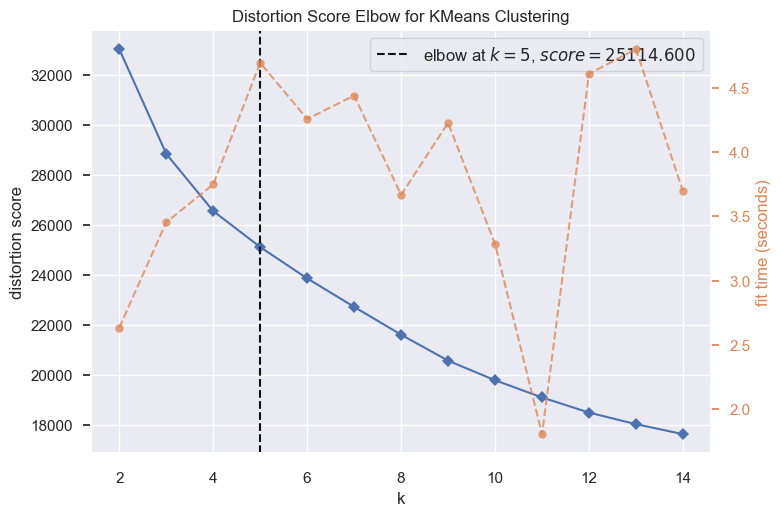

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
k_range = range(2, 15)
visualizer = KElbowVisualizer(KMeans(n_init=20), k=k_range, random_state=104)
visualizer.fit(customer_train_data_)
visualizer.show()

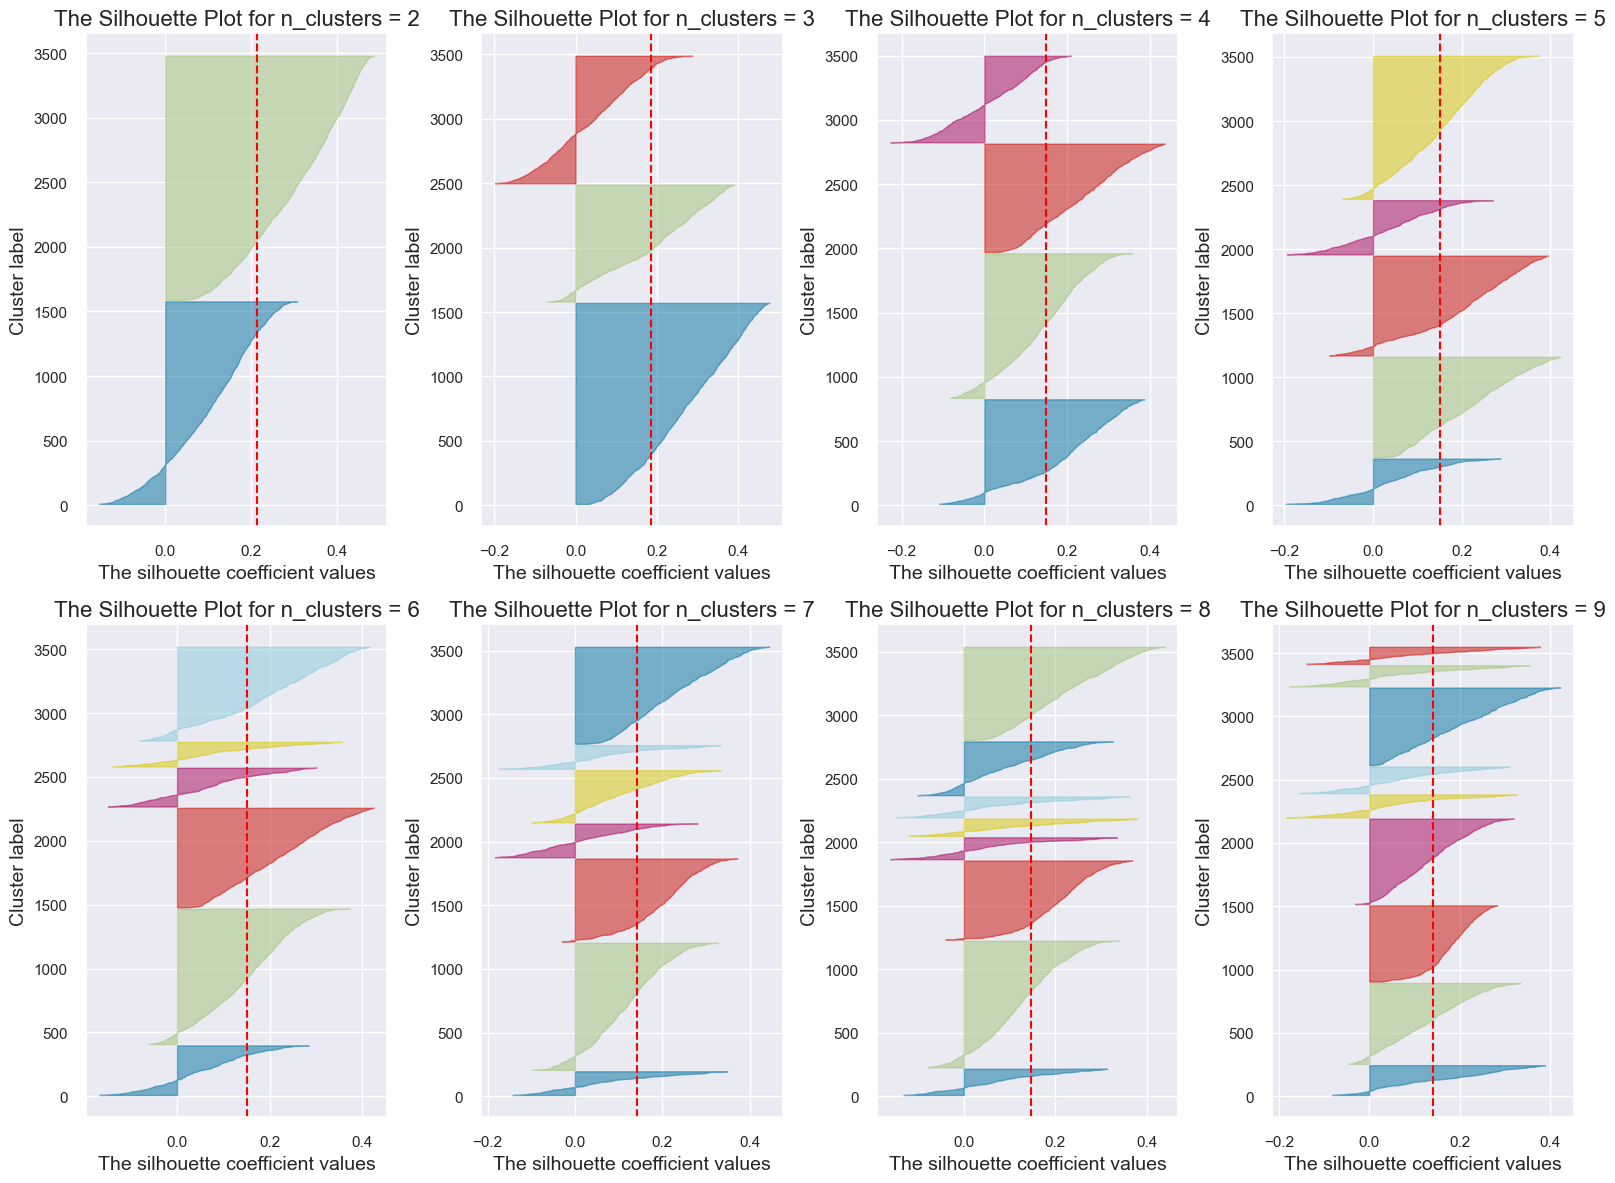

In [64]:
silhouette_plots(customer_train_data_,range(2,10),2)

### 2D cluster visual

In [65]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=100)
customer_clusters = kmeans.fit_predict(customer_train_data)

In [66]:
# visuals to see if clusters are disjoint
plotter = DimensionalityReductionPlotter(
    customer_train_data, customer_clusters, dimensions=2, method="tsne"
)
plotter.plot_reduced_dimensions(opacity=1, width_line=0.1)

The clusters are well seperated, some overlap may exist between 0 & 1, let's check the plot in 3D. 

### 3D cluster visual

In [67]:
plotter_3d = DimensionalityReductionPlotter(
    customer_train_data, customer_clusters, dimensions=3, method="tsne"
)
plotter_3d.plot_reduced_dimensions(opacity=1, width_line=0.1)

Looks like cluster 0 could be a subset of cluster 1, let's check more

In [68]:
customer_train_data["cluster"] = customer_clusters

### Mean customer representation

In [69]:
agg_train["cluster"] = customer_clusters
agg_train.head(3)

CustomerID  orderCounts  minPrice  avgPrice  maxPrice  totalPrice  \
0      12348            4    187.44    359.31    652.80     1437.24   
1      12349            1   1457.55   1457.55   1457.55     1457.55   
2      12350            1    294.40    294.40    294.40      294.40   

   avgQuantity          firstOrder           lastOrder  daysBetweenOrders  \
0        583.0 2010-12-16 19:09:00 2011-09-25 13:13:00               94.0   
1        630.0 2011-11-21 09:51:00 2011-11-21 09:51:00              999.0   
2        196.0 2011-02-02 16:01:00 2011-02-02 16:01:00              999.0   

   customerAgeDays  Country  Category0  Category1  Category2  Category3  \
0              358  Finland   8.431977   6.755797  44.923369   7.113971   
1               19    Italy  19.957463  18.280676  27.929745  14.234160   
2              310   Norway  34.273098  11.820652  32.404891  15.489130   

   Category4  cluster  
0  32.774887        3  
1  19.597955        2  
2   6.012228        2

In [113]:
key_customer_per_cluster = (
    agg_train.groupby("cluster")
    .agg(
        {
            "CustomerID": "count",
            "orderCounts": "mean",
            "minPrice": "mean",
            "avgPrice": "mean",
            "maxPrice": "mean",
            "totalPrice": "mean",
            "avgQuantity": "mean",
            "daysBetweenOrders": "mean",
            "customerAgeDays": "mean",
            "Country": lambda x: x.value_counts().index[0],
            "Category0": "mean",
            "Category1": "mean",
            "Category2": "mean",
            "Category3": "mean",
            "Category4": "mean"
        }
    )
    .reset_index()
    .rename(columns={"CustomerID": "ClusterSize"}) 
)
key_customer_per_cluster

cluster  ClusterSize  orderCounts    minPrice    avgPrice     maxPrice  \
0        0         1074     4.395717  117.267076  207.266609   309.043780   
1        1          661     1.142209  135.179909  137.562722   140.063086   
2        2          813     1.220172  526.954834  550.098715   573.242595   
3        3          912     8.914474  207.805186  550.560272  1129.910373   

    totalPrice  avgQuantity  daysBetweenOrders  customerAgeDays  \
0   848.705102   119.109379          74.635958       244.306331   
1   148.758079    80.550504         904.677988       176.529501   
2   667.420775   332.659287         806.644526       151.129151   
3  5227.195943   328.402577          53.060016       292.252193   

          Country  Category0  Category1  Category2  Category3  Category4  
0  United Kingdom  21.870710  18.092639  24.685557  19.577240  15.773854  
1  United Kingdom  23.257692  18.469108  26.035165  19.534556  12.703479  
2  United Kingdom  23.713272  18.583163  23.712149  17.832193  16.159224  
3  United Kingdom  23.380619  17.970997  24.852362  17.718039  16.077983

Taking the centroid point of the each cluster, cluster 0 has a smaller order compared to 1. So we can confirm all clusters are well sepearetd. Let's describe all clusters in business terms.

As we have 14 features on customers, it's not as easy to quickly summarize the main characters of each cluster. A visual would help.

### Radar charts

In [71]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart:
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels=6):

        angles = np.arange(0, 360, 360.0 / len(variables))

        ix, iy = location[:]
        size_x, size_y = sizes[:]

        axes = [
            fig.add_axes([ix, iy, size_x, size_y], polar=True, label="axes{}".format(i))
            for i in range(len(variables))
        ]

        _, text = axes[0].set_thetagrids(angles, labels=variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            grid_label = [""] + ["{:.0f}".format(x) for x in grid[0:-1]]
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform=self.ax.transAxes, *args, **kw)

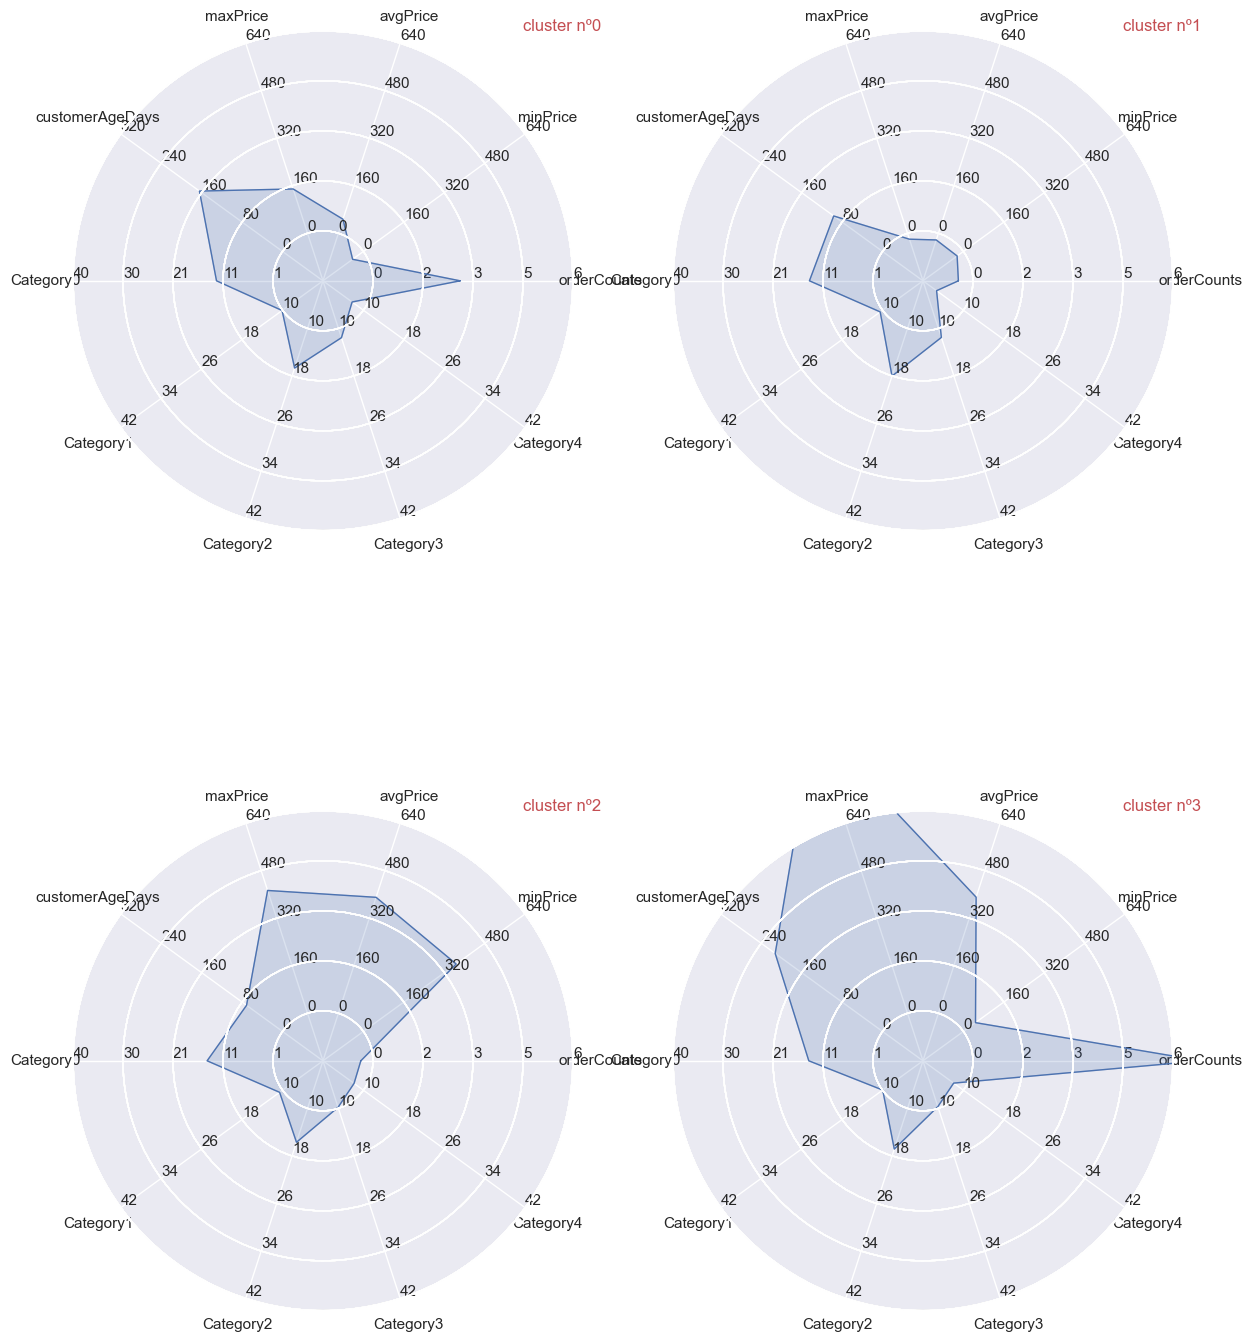

In [148]:
fig = plt.figure(figsize=(10, 12))

attributes = [
    "orderCounts",
    "minPrice",
    "avgPrice",
    "maxPrice",
    "customerAgeDays",
    "Category0",
    "Category1",
    "Category2",
    "Category3",
    "Category4"
]
ranges = [
    [0.01, 8],
    [0.01, 800],
    [0.01, 800],
    [0.01, 800],
    [0.01, 400],
    [1.01, 50],
    [10.01, 50],
    [10.01, 50],
    [10.01, 50],
    [10.01, 50],
]
index = range(k)

n_groups = k
i_cols = 2
i_rows = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(k):
    ix = ind % 2
    iy = i_rows - ind // 2
    pos_x = ix * (size_x + 0.1)
    pos_y = iy * (size_y + 0.15)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]
    # ______________________________________________________
    data = np.array(key_customer_per_cluster.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color="b", linewidth=1.0)
    radar.fill(data, alpha=0.2, color="b")
    radar.title(title="cluster nº{}".format(index[ind]), color="r")
    ind += 1

Cluster 0: Biggest cluter, regular customers with average orders.  
Cluster 1: One time shopper, small basket.
Cluster 2: Big basket but infrequent shopper.
Cluster 3: Most frequent shopper and stayed the longest. Star customers

# *Try out sentence embedding with k clustering
https://towardsdatascience.com/mastering-customer-segmentation-with-llm-3d9008235f41#3a33

In [73]:
from sentence_transformers import SentenceTransformer

/Users/graceyang/Library/Python/3.9/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [74]:
agg_train

CustomerID  orderCounts  minPrice     avgPrice  maxPrice  totalPrice  \
0         12348            4    187.44   359.310000    652.80     1437.24   
1         12349            1   1457.55  1457.550000   1457.55     1457.55   
2         12350            1    294.40   294.400000    294.40      294.40   
3         12352            7    104.35   197.962857    296.50     1385.74   
4         12353            1     89.00    89.000000     89.00       89.00   
...         ...          ...       ...          ...       ...         ...   
3455      18278            1    173.90   173.900000    173.90      173.90   
3456      18280            1    180.60   180.600000    180.60      180.60   
3457      18281            1     80.82    80.820000     80.82       80.82   
3458      18283           16      1.95   130.558125    313.65     2088.93   
3459      18287            3     70.68   612.426667   1001.32     1837.28   

      avgQuantity          firstOrder           lastOrder  daysBetweenOrders  \
0      583.000000 2010-12-16 19:09:00 2011-09-25 13:13:00          94.000000   
1      630.000000 2011-11-21 09:51:00 2011-11-21 09:51:00         999.000000   
2      196.000000 2011-02-02 16:01:00 2011-02-02 16:01:00         999.000000   
3       75.142857 2011-02-16 12:33:00 2011-11-03 14:37:00          43.333333   
4       20.000000 2011-05-19 17:47:00 2011-05-19 17:47:00         999.000000   
...           ...                 ...                 ...                ...   
3455    66.000000 2011-09-27 11:58:00 2011-09-27 11:58:00         999.000000   
3456    45.000000 2011-03-07 09:52:00 2011-03-07 09:52:00         999.000000   
3457    54.000000 2011-06-12 10:53:00 2011-06-12 10:53:00         999.000000   
3458    87.187500 2011-01-06 14:14:00 2011-12-06 12:02:00          22.200000   
3459   528.666667 2011-05-22 10:39:00 2011-10-28 09:29:00          79.000000   

      customerAgeDays         Country  Category0  Category1  Category2  \
0                 358         Finland   8.431977   6.755797  44.923369   
1                  19           Italy  19.957463  18.280676  27.929745   
2                 310          Norway  34.273098  11.820652  32.404891   
3                 297          Norway  13.378619  16.083982  31.003267   
4                 204         Bahrain  13.033708   0.000000  86.966292   
...               ...             ...        ...        ...        ...   
3455               74  United Kingdom  28.464635  18.401380  36.055204   
3456              278  United Kingdom   9.800664   0.000000  38.122924   
3457              181  United Kingdom  33.444692   0.000000  39.903489   
3458              337  United Kingdom  19.992823  17.559519  20.404050   
3459              202  United Kingdom   9.235340  14.638200  48.106641   

      Category3  Category4  cluster  
0      7.113971  32.774887        3  
1     14.234160  19.597955        2  
2     15.489130   6.012228        2  
3     17.564062  21.970069        0  
4      0.000000   0.000000        1  
...         ...        ...      ...  
3455   0.000000  17.078781        1  
3456  33.970100  18.106312        1  
3457   6.236080  20.415739        1  
3458  21.873915  20.169692        0  
3459   7.370541  20.649279        3  

[3460 rows x 18 columns]

In [75]:
agg_train_copy = agg_train.drop(columns=['CustomerID','cluster'])

In [76]:
def compile_text(x):
    text =  f"""orderCounts: {x['orderCounts']},  
                minPrice: {x['minPrice']}, 
                avgPrice: {x['avgPrice']}, 
                maxPrice: {x['maxPrice']}, 
                totalPrice: {x['totalPrice']}, 
                avgQuantity: {x['avgQuantity']}, 
                firstOrder: {x['firstOrder']}, 
                lastOrder: {x['lastOrder']}, 
                daysBetweenOrders: {x['daysBetweenOrders']}, 
                customerAgeDays: {x['customerAgeDays']}, 
                Country: {x['Country']},
                Category0: {x['Category0']},
                Category1: {x['Category1']},
                Category2: {x['Category2']},
                Category3: {x['Category3']},
                Cateogy4: {x['Category4']}
            """
    return text

In [77]:
text = agg_train_copy.apply(lambda x: compile_text(x), axis=1).tolist()

In [78]:
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences=text,
                         show_progress_bar=True,
                         normalize_embeddings=True)
df_embedding = pd.DataFrame(embeddings)

/Users/graceyang/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Batches:   0%|          | 0/109 [00:00<?, ?it/s]

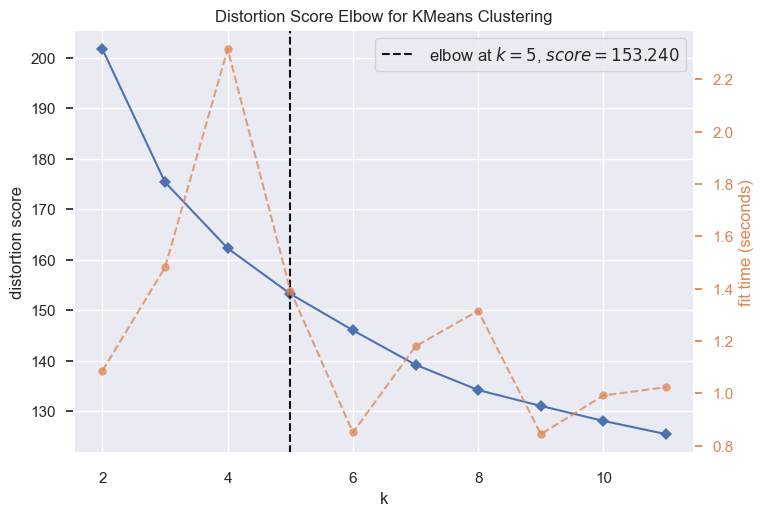

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
visualizer = KElbowVisualizer(KMeans(n_init = 10),k=(2,12))
visualizer.fit(df_embedding)
visualizer.show()

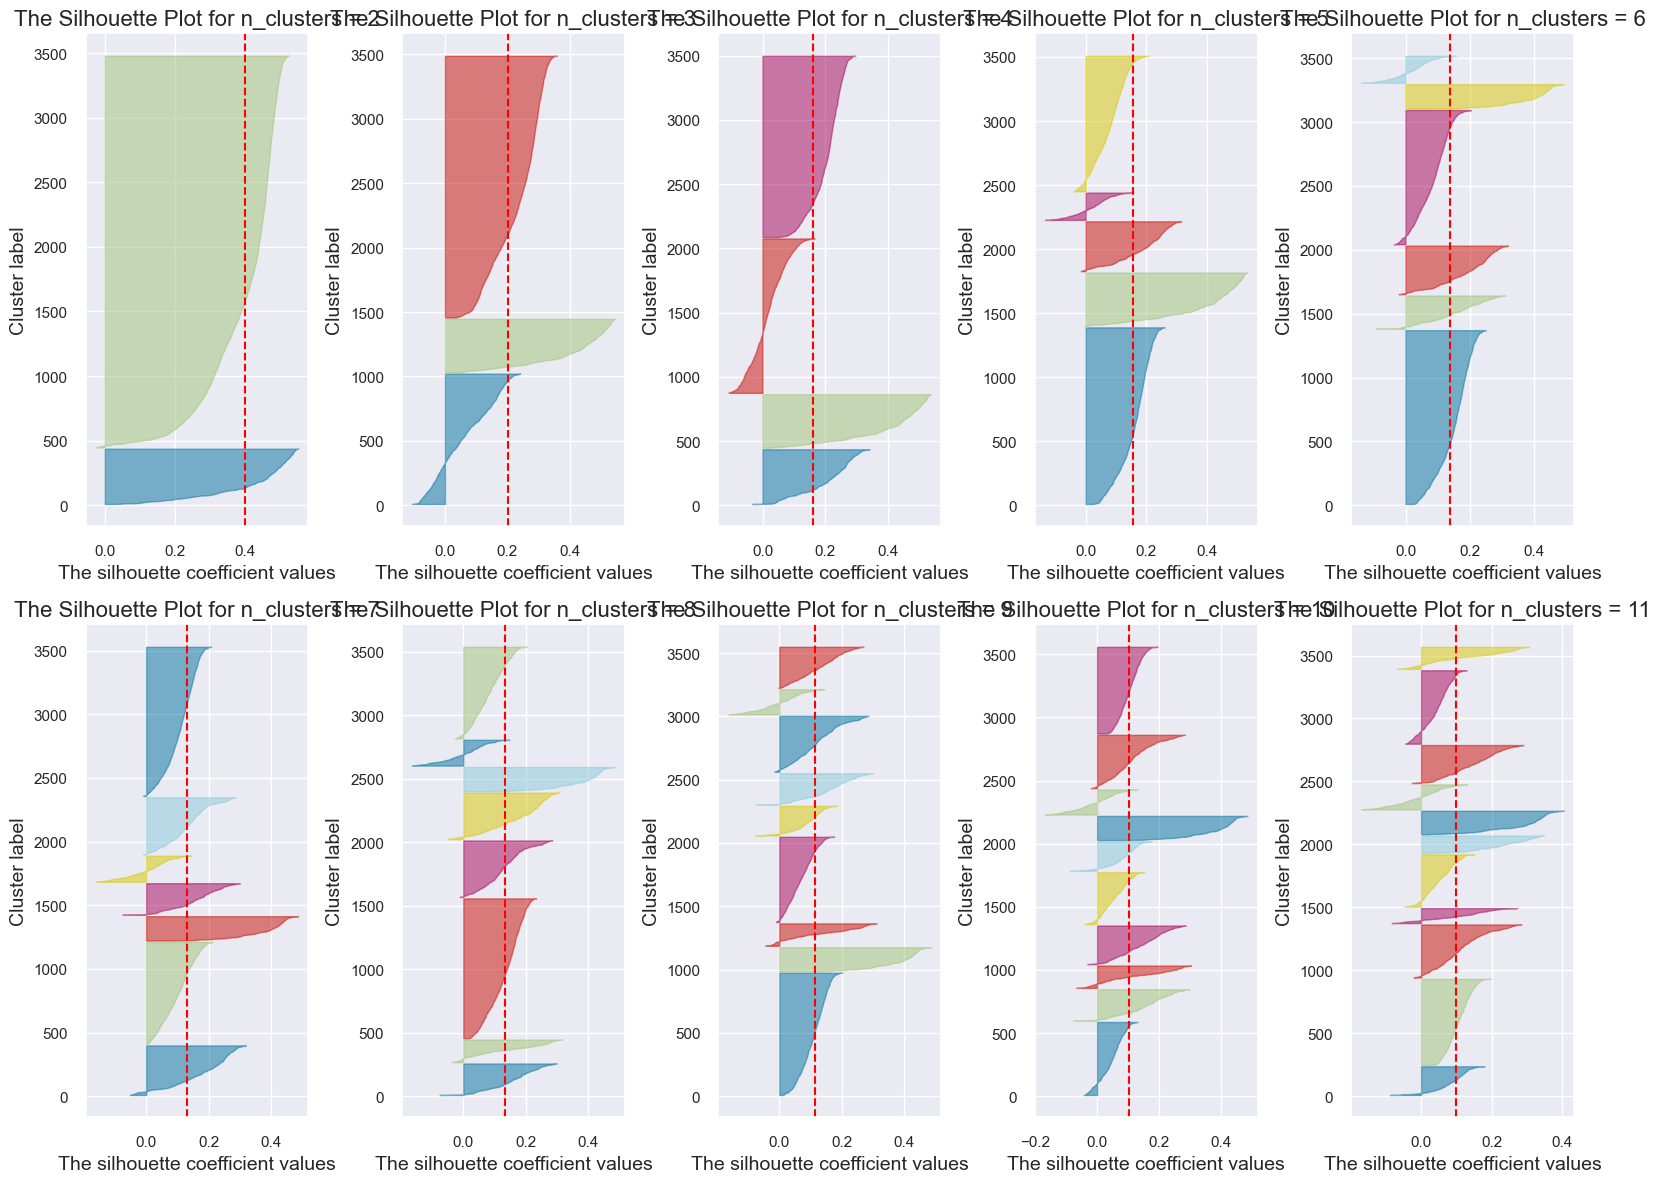

In [80]:
silhouette_plots(df_embedding, k_range = range(2,12), num_rows = 2)

From the elbow chart, k means using sentence embedding have much smaller distortion score(within cluster sum of squares), and quicker at fitting. But the clusters size are quite imbalanced, and quality of clusters are not improved, as no difference of the silhouette scores compared to the normal k means method in the previous chapter.

# 5. Classification Models

Using the agg_train data with assigned cluster to find the best performing classfication model. As it will be used on new customers (<=2 orders), I will remove 'totalPrice','cusotmerAgeDays', and 'Country' for classification. 

In [81]:
agg_train.head(3)

CustomerID  orderCounts  minPrice  avgPrice  maxPrice  totalPrice  \
0      12348            4    187.44    359.31    652.80     1437.24   
1      12349            1   1457.55   1457.55   1457.55     1457.55   
2      12350            1    294.40    294.40    294.40      294.40   

   avgQuantity          firstOrder           lastOrder  daysBetweenOrders  \
0        583.0 2010-12-16 19:09:00 2011-09-25 13:13:00               94.0   
1        630.0 2011-11-21 09:51:00 2011-11-21 09:51:00              999.0   
2        196.0 2011-02-02 16:01:00 2011-02-02 16:01:00              999.0   

   customerAgeDays  Country  Category0  Category1  Category2  Category3  \
0              358  Finland   8.431977   6.755797  44.923369   7.113971   
1               19    Italy  19.957463  18.280676  27.929745  14.234160   
2              310   Norway  34.273098  11.820652  32.404891  15.489130   

   Category4  cluster  
0  32.774887        3  
1  19.597955        2  
2   6.012228        2

## Train test split

In [82]:
agg_train_new = agg_train[agg_train['orderCounts']<=2]

In [83]:
classification_features = ['avgPrice','minPrice', 'maxPrice','avgQuantity', 'daysBetweenOrders','Category0', 'Category1', 'Category2', 'Category3', 'Category4']
X = agg_train[classification_features]
y = agg_train['cluster']

In [84]:
# split 20% test for testing the classification models
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

## Models

In [85]:
# define a class that allows several classifiers
# Disable the tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"
class Class_Fit():
  def __init__(self, clf, params = None):
    if params:
      self.clf = clf(**params)
    else:
      self.clf = clf()

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def predict(self, x):
    self.clf.predict(x)

  def grid_search(self,parameters, Kfold):
    self.grid = GridSearchCV(estimator=self.clf, param_grid = parameters, cv=Kfold)

  def grid_fit(self, X, Y):
    self.grid.fit(X,Y)

  # output the accuracy score after predict
  def grid_predict(self, X, Y):
    self.predictions = self.grid.predict(X)
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(Y, self.predictions)))

### Support Vector Machine Classifier (SVC)

In [86]:
params = {'dual': 'auto', 'max_iter': 10000}
svc = Class_Fit(clf=svm.LinearSVC, params=params)

parameters = [{'C': np.logspace(-2, 2, 10)}]
svc.grid_search(parameters=parameters, Kfold=5)
svc.grid_fit(X_train, y_train)
svc.grid_predict(X_test, y_test)


Accuracy: 87.28%


In [87]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


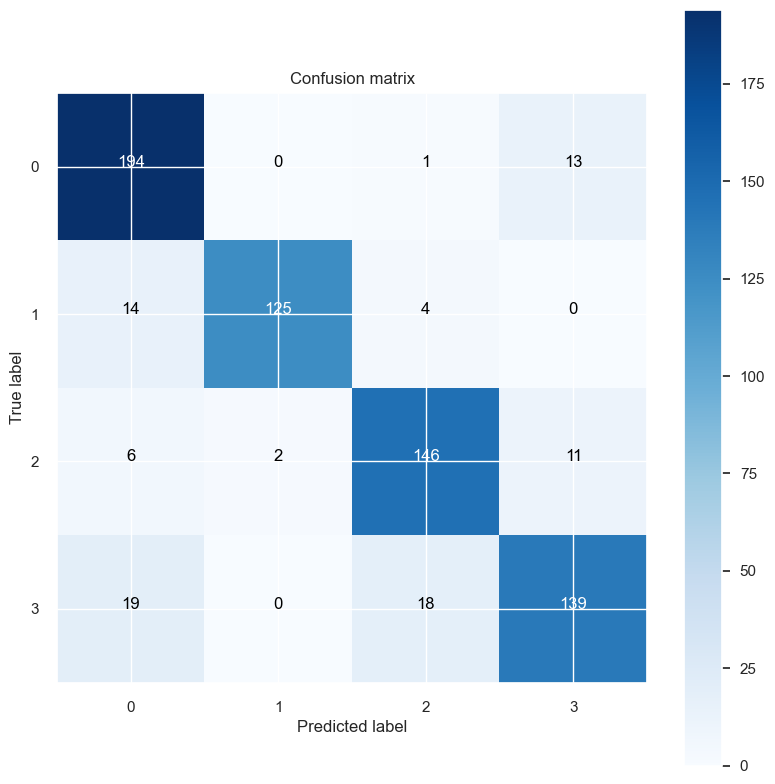

In [88]:
class_names = [i for i in range(k)]
cnf_matrix = confusion_matrix(y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')


The classification works well on all categories. The incorrect classification mostly mis assigned customer to cluster 3. This could be becuase we are limiting to customers with 2 orders (as we want to classify new customers). 

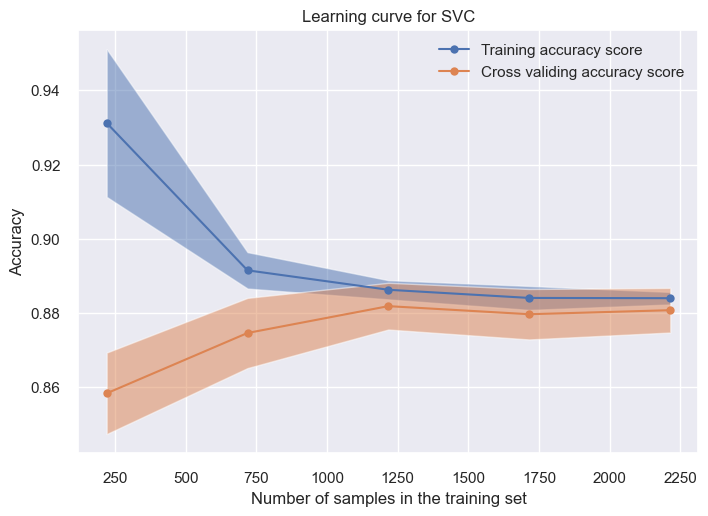

In [89]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}



LearningCurveDisplay.from_estimator(svc.grid.best_estimator_,  **common_params)
# change legend labels
legend_labels = ['Training accuracy score', 'Cross validing accuracy score']
for text,label in zip(plt.gca().get_legend().get_texts(), legend_labels):
  text.set_text(label)
plt.title("Learning curve for SVC")
plt.show()

Learning curve is to check the performance of the model. The model generize well as the gap between accuracy scores are small. So more samples will not benefit the model training. 

### Logisitic Regression


In [90]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = Class_Fit(clf = LogisticRegression, params = {'max_iter':1000})
lr.grid_search(parameters = [{'C':np.logspace(-2,2,5)}], Kfold = 5)

lr.grid_fit(X=X_train_scaled, Y=y_train)
lr.grid_predict(X_test_scaled, y_test)

Accuracy: 88.44%


### KNN

In [91]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = y_train)
knn.grid_predict(X_test, y_test)

Accuracy: 89.45%


### Decision Tree

In [92]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = y_train)
tr.grid_predict(X_test, y_test)

Accuracy: 86.42%


### Radom Forest

In [93]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = y_train)
rf.grid_predict(X_test, y_test)

Accuracy: 89.74%


### Ada Boost

In [94]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = y_train)
ada.grid_predict(X_test, y_test)

Accuracy: 81.79%


### Gradient Boosting

In [95]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = y_train)
gb.grid_predict(X_test, y_test)

Accuracy: 90.17%


### Voting Classifier

Votting classifier combines the results of the different classifiers presented in the previously improve the classification model, as the votting classifier select the customer category as the one indicated by the majority of classifiers.

In [96]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [97]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('lr', lr_best)], voting='soft')    

In [98]:
votingC = votingC.fit(X_train, y_train)
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*accuracy_score(y_test, predictions)))

Precision: 89.74 % 


/Users/graceyang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion matrix, without normalization


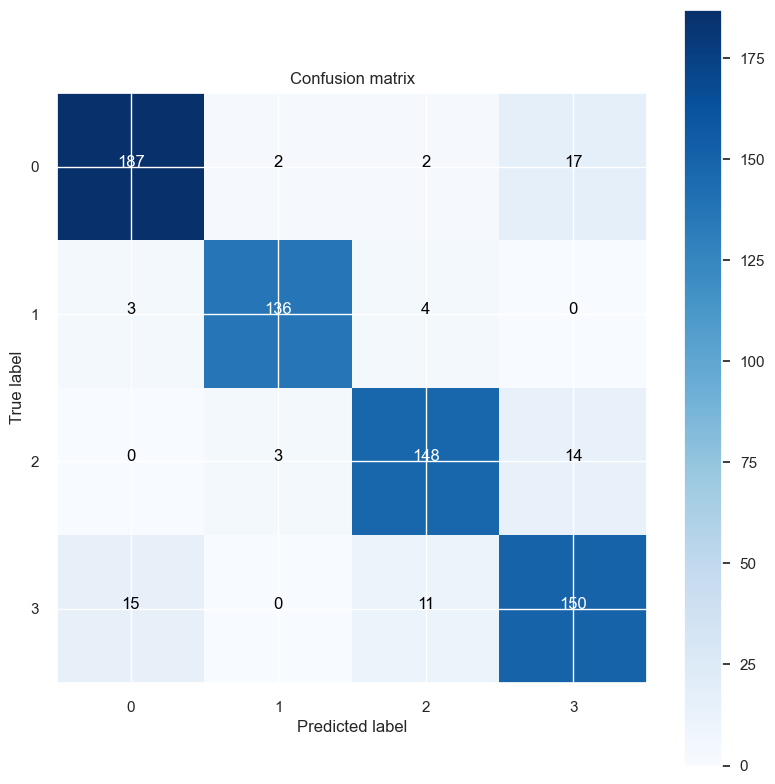

In [99]:
class_names = [i for i in range(k)]
votingC_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize = (8,8))
plot_confusion_matrix(votingC_matrix, classes=class_names, normalize = False, title='Confusion matrix')


It improves from the previously best accuracy of 94.08% to 95.09%!

# 6.Testing Prediction

In [182]:
# get the first 2 orders of the any test customer 
test_customers_df_sorted = test_customers_df[['CustomerID', 'InvoiceNo','InvoiceDate']].drop_duplicates().sort_values(by=['CustomerID', 'InvoiceDate'])
first_two_orders_df = test_customers_df_sorted.groupby('CustomerID').head(2)
sub_test_customer_df=test_customers_df[test_customers_df['InvoiceNo'].isin(first_two_orders_df['InvoiceNo'])]                                                                   

In [183]:
# Pre processing steps on test_customers_df for clustering
agg_test = pd.DataFrame()
agg_test = customer_table_build(sub_test_customer_df)
test_num_sca = pd.DataFrame (pt.fit_transform(
    agg_test[
            [
                "orderCounts",
                "minPrice",
                "avgPrice",
                "maxPrice",
                "totalPrice",
                "avgQuantity",
                "daysBetweenOrders",
                "customerAgeDays",
                "Category0",
                "Category1",
                "Category2",
                "Category3",
                "Category4",
            ]
        ]
    ),
    columns=pt.get_feature_names_out(),
)
# test_country_encoded = pd.DataFrame.sparse.from_spmatrix(
#     enc.fit_transform(agg_test[["Country"]]), columns=enc.get_feature_names_out()

customer_test_data = test_num_sca

In [184]:
test_customer_clusters = kmeans.predict(customer_test_data)
agg_test['cluster'] = test_customer_clusters

In [185]:
# Classification on new customers
agg_test_new = agg_test[agg_test['orderCounts']<=10]
X = agg_test_new[classification_features]
Y = agg_test_new['cluster']

In [186]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Accuracy: 80.92%
______________________________ 
Logostic Regression
Accuracy: 45.66%
______________________________ 
k-Nearest Neighbors
Accuracy: 85.43%
______________________________ 
Decision Tree
Accuracy: 79.31%
______________________________ 
Random Forest
Accuracy: 84.62%
______________________________ 
Gradient Boosting
Accuracy: 83.35%


/Users/graceyang/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:457: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



In [187]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*accuracy_score(Y, predictions)))


Precision: 86.13 % 


Confusion matrix, without normalization


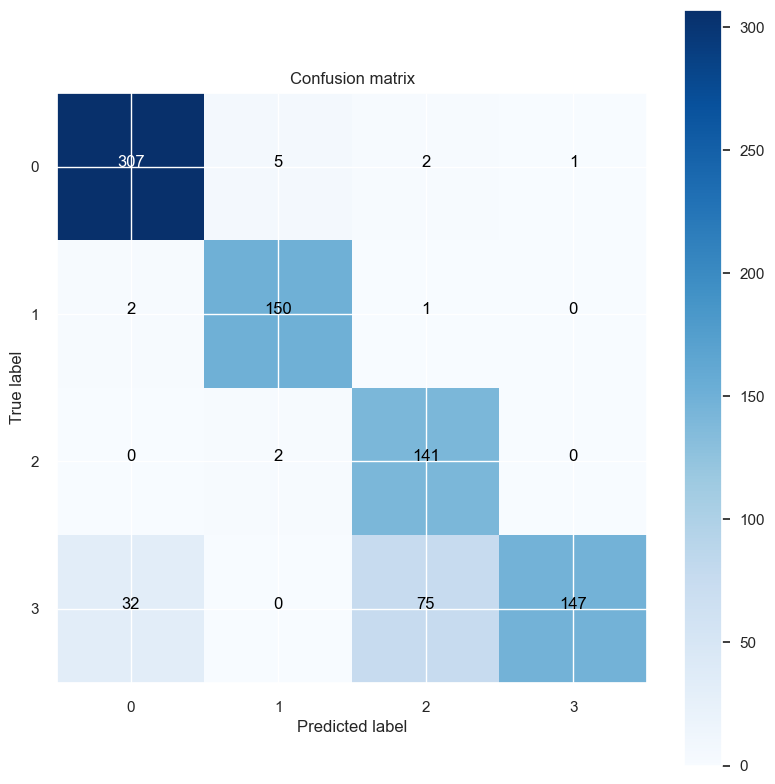

In [188]:
class_names = [i for i in range(k)]
test_customers_matrix = confusion_matrix(Y, predictions)
plt.figure(figsize = (8,8))
plot_confusion_matrix(test_customers_matrix, classes=class_names, normalize = False, title='Confusion matrix')


The classifier works pretty well on the test set, and the least accurate categories are those customer who are the most loyal and frequent purchaser. So it is quite understandable because we only used the first 2 purchase for the prediction.